In [117]:
import datetime as dt
# import holidays       
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [118]:
df = pd.read_csv("MRF.NS (1).csv", parse_dates=True, index_col='Date')
df.dropna(inplace=True)

In [119]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [120]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-10-11,849.950012,852.000000,836.099976,838.00,761.472168,436.0
2002-10-14,825.000000,856.950012,825.000000,842.50,765.561401,264.0
2002-10-15,842.500000,842.500000,842.500000,842.50,765.561401,0.0
2002-10-16,849.450012,854.950012,840.250000,850.25,772.603394,138.0
2002-10-17,830.099976,853.750000,823.400024,840.25,763.516663,231.0


<Axes: xlabel='Date'>

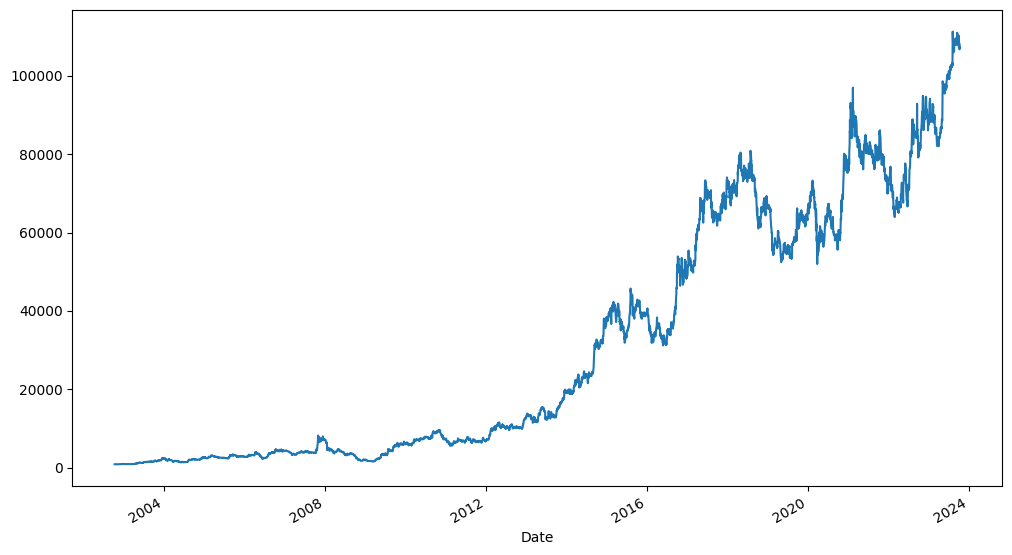

In [164]:
df['Close'].plot(figsize=(12, 7))

In [121]:
dfClose = pd.DataFrame(df['Close'])

<Axes: xlabel='Date'>

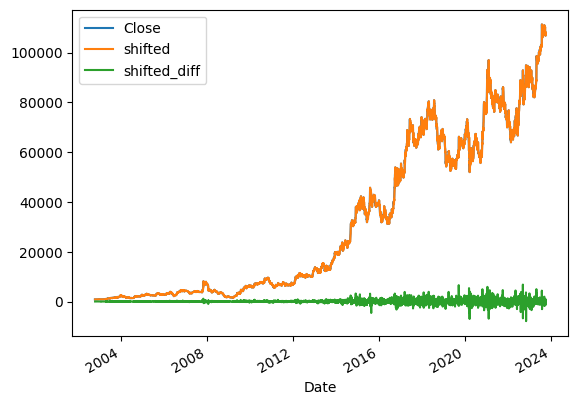

In [161]:
dfClose

In [123]:
# seasonal_decompose(df['Close']) # error here proves theres no seasonality I THINK; Edit: That seems to be the case...
# Read the first answer: https://stats.stackexchange.com/questions/482089/statsmodels-seasonal-decompose-what-is-the-right-period-of-the-series-in-th

In [124]:
dfClose['shifted'] = dfClose['Close'].shift(1)
dfClose['shifted_diff'] = dfClose['Close']-dfClose['shifted']

In [125]:
dfClose.head()

,Close,shifted,shifted_diff
Date,,,
2002-10-11,838.00,NaN,NaN
2002-10-14,842.50,838.00,4.50
2002-10-15,842.50,842.50,0.00
2002-10-16,850.25,842.50,7.75
2002-10-17,840.25,850.25,-10.00


In [126]:
adfuller(dfClose['shifted_diff'].dropna(), autolag='AIC')

(-15.021664146057237,
 1.0202159450463938e-27,
 22,
 5188,
 {'1%': -3.431611090689047,
  '5%': -2.862097270162247,
  '10%': -2.5670666348191573},
 82900.83111328582)

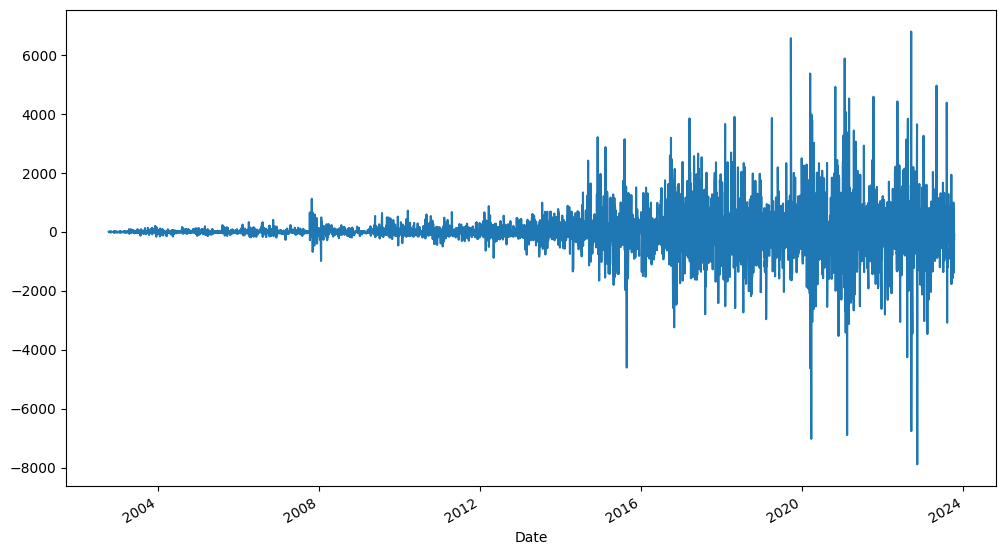

In [127]:
# p <0.05, move ahead with this
dfClose['shifted_diff'].plot(figsize=(12, 7));

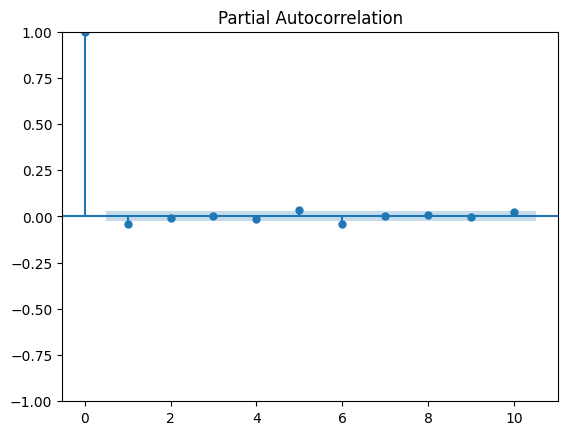

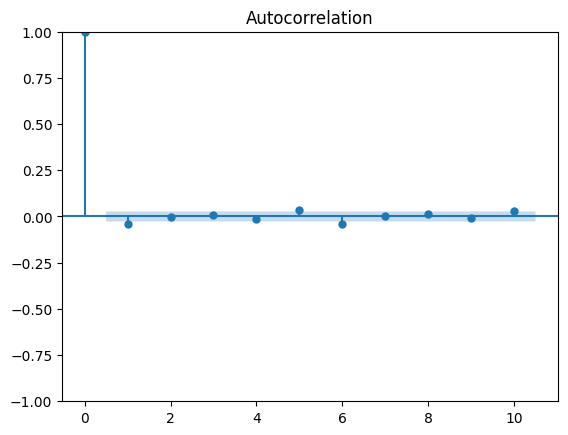

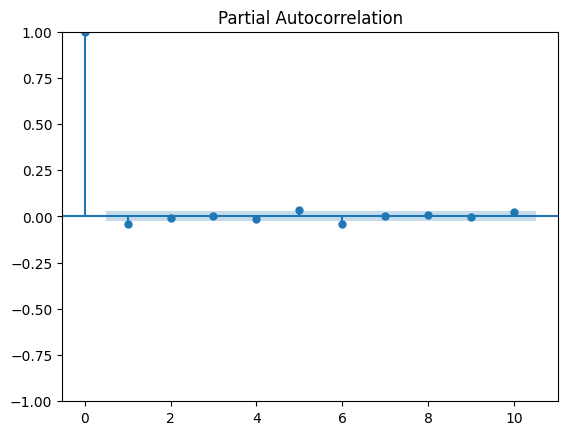

In [128]:
plot_acf(dfClose['shifted_diff'].dropna(), lags=10)
plot_pacf(dfClose['shifted_diff'].dropna(), lags=10)

In [129]:
# from acf, p = 1
# from pacf, q = 1
# 1-shift difference, d = 1

In [130]:
order = (1, 1, 1)

In [131]:
from sklearn.model_selection import TimeSeriesSplit

In [132]:
len(dfClose['Close'])

5212

In [133]:
train_len = np.round(0.7*len(dfClose['Close']))

In [134]:
test_len = np.round(len(dfClose['Close'])-train_len)

In [135]:
train_len, test_len

(3648.0, 1564.0)

In [136]:
#verification
train_len+test_len == len(dfClose['Close'])

True

In [137]:
trainingData = df['Close'].iloc[0:int(train_len)]

In [138]:
len(trainingData)

3648

In [139]:
trainingData.head()

Date
2002-10-11    838.00
2002-10-14    842.50
2002-10-15    842.50
2002-10-16    850.25
2002-10-17    840.25
Name: Close, dtype: float64

In [140]:
trainingData.tail()

Date
2017-06-07    68985.953125
2017-06-08    71129.648438
2017-06-09    72901.250000
2017-06-12    73331.601563
2017-06-13    72369.296875
Name: Close, dtype: float64

In [141]:
testingData = df['Close'].iloc[int(train_len):int(train_len)+int(test_len)]

In [142]:
testingData

Date
2017-06-14     71102.148438
2017-06-15     72847.453125
2017-06-16     71978.101563
2017-06-19     71760.203125
2017-06-20     71656.203125
                  ...      
2023-10-04    106901.398438
2023-10-05    106770.500000
2023-10-06    107550.250000
2023-10-09    107266.953125
2023-10-10    107204.101563
Name: Close, Length: 1564, dtype: float64

In [143]:
dfClose['Close'].tail()
# last value matches

Date
2023-10-04    106901.398438
2023-10-05    106770.500000
2023-10-06    107550.250000
2023-10-09    107266.953125
2023-10-10    107204.101563
Name: Close, dtype: float64

In [144]:
model_fit = ARIMA(trainingData, order=(1, 1, 0)).fit()

In [145]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3648
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -26893.013
Date:                Wed, 11 Oct 2023   AIC                          53790.026
Time:                        19:10:11   BIC                          53802.430
Sample:                             0   HQIC                         53794.444
                               - 3648                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0615      0.007      8.593      0.000       0.048       0.076
sigma2      1.488e+05   1020.933    145.757      0.000    1.47e+05    1.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             77868.50
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):             118.83   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [146]:
model_fit.predict()

Date
2002-10-11        0.000000
2002-10-14      844.701712
2002-10-15      842.776911
2002-10-16      842.500000
2002-10-17      850.726902
                  ...     
2017-06-07    68850.421775
2017-06-08    68996.134413
2017-06-09    71261.562412
2017-06-12    73010.266893
2017-06-13    73358.083584
Name: predicted_mean, Length: 3648, dtype: float64

In [147]:
predictions = model_fit.predict()

In [148]:
np.sqrt(mean_squared_error(dfClose['Close'].iloc[1:int(train_len)], predictions[1:]))

385.70416208786264

In [149]:
model_fit.predict(864) #this is the last value

Date
2006-02-24     3046.892483
2006-02-27     3019.599408
2006-02-28     3060.043025
2006-03-01     3059.816863
2006-03-02     3135.068992
                  ...     
2017-06-07    68850.421775
2017-06-08    68996.134413
2017-06-09    71261.562412
2017-06-12    73010.266893
2017-06-13    73358.083584
Name: predicted_mean, Length: 2784, dtype: float64

In [150]:
model_fit.predict(865) # observe: this is technically the prediction of the next value in the model after the last value with dates
# also observe: the next value after the last value with dates is technically the beginning of the testing data
# so model_fit.predict(866 will be prediction of the second value of the testing data) (Note: NOT the actual/realised value, this is what the model has predicted)
# logically, one needs values after the beginning of the testing data which the model has predicted (including the first value of the same)

Date
2006-02-27     3019.599408
2006-02-28     3060.043025
2006-03-01     3059.816863
2006-03-02     3135.068992
2006-03-03     3253.678976
                  ...     
2017-06-07    68850.421775
2017-06-08    68996.134413
2017-06-09    71261.562412
2017-06-12    73010.266893
2017-06-13    73358.083584
Name: predicted_mean, Length: 2783, dtype: float64

In [151]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
test_preds = pd.DataFrame({'predicted_test_values': [model_fit.predict(i).iloc[0] for i in range (865, 865+int(test_len))]});
# 865+test_len yields the last index/last value of the testing data

In [152]:
# Q. Why is the iloc[0] added above? Uncomment the following line and see what comes along with the predicted value (dtype: float64 also comes up in the list of values if you dont iloc it)
# model_fit.predict(865)

In [153]:
test_preds['actual_test_values'] = testingData.values

In [154]:
testingData #observe the dates here, they're needed for the next step

Date
2017-06-14     71102.148438
2017-06-15     72847.453125
2017-06-16     71978.101563
2017-06-19     71760.203125
2017-06-20     71656.203125
                  ...      
2023-10-04    106901.398438
2023-10-05    106770.500000
2023-10-06    107550.250000
2023-10-09    107266.953125
2023-10-10    107204.101563
Name: Close, Length: 1564, dtype: float64

In [155]:
test_preds.index=testingData.index

In [156]:
test_preds #a perfectly new testing dataset to work on

,predicted_test_values,actual_test_values
Date,,
2017-06-14,3019.599408,71102.148438
2017-06-15,3060.043025,72847.453125
2017-06-16,3059.816863,71978.101563
2017-06-19,3135.068992,71760.203125
2017-06-20,3253.678976,71656.203125
...,...,...
2023-10-04,10098.878349,106901.398438
2023-10-05,10183.220599,106770.500000
2023-10-06,10267.335368,107550.250000


In [157]:
np.sqrt(mean_squared_error(test_preds['actual_test_values'], test_preds['predicted_test_values']))

69282.58932838401

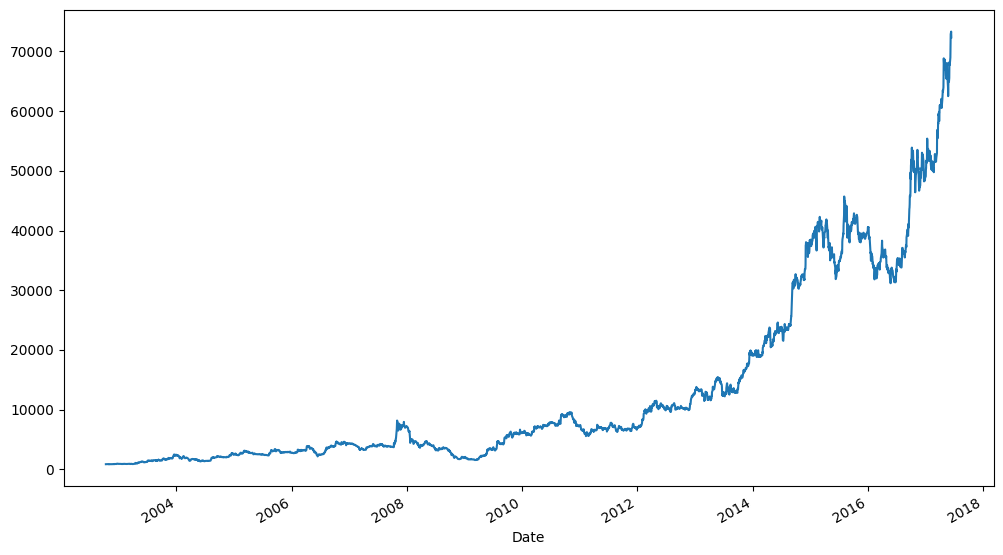

In [158]:
trainingData.plot(figsize=(12, 7));

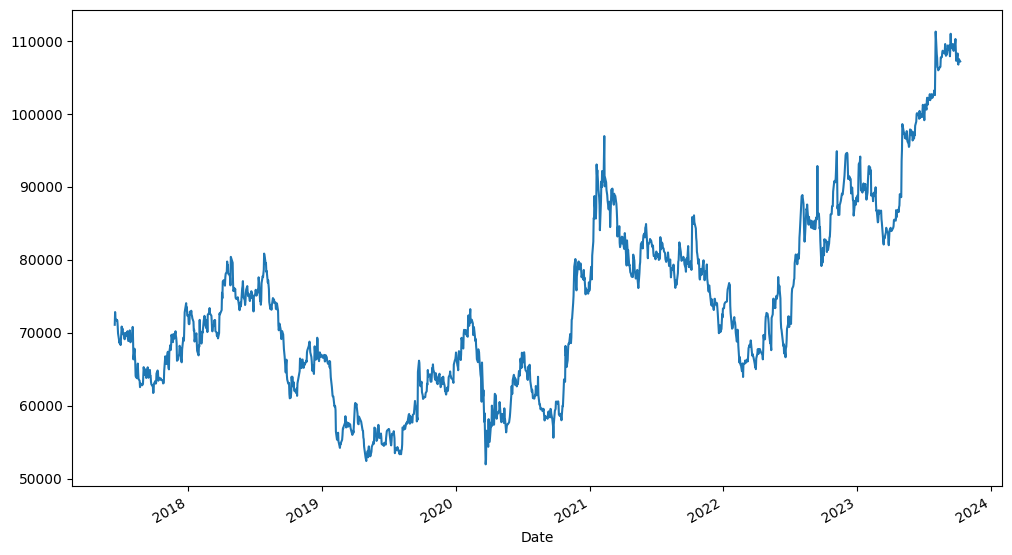

In [159]:
test_preds['actual_test_values'].plot(figsize=(12, 7));

In [160]:
model_fit.predict()['17-03-2021']

KeyError: '17-03-2021'

In [ ]:
model_fit.predict().tail(50)

Date
28-01-2022    70705.144340
31-01-2022    71295.358465
01-02-2022    72104.958222
02-02-2022    71548.723019
03-02-2022    71465.240309
04-02-2022    71012.143893
07-02-2022    70057.974390
08-02-2022    68862.302562
09-02-2022    69393.349542
10-02-2022    70374.000139
11-02-2022    69803.774579
14-02-2022    68314.215572
15-02-2022    66050.187213
16-02-2022    66640.646840
17-02-2022    66168.975399
18-02-2022    65643.351038
21-02-2022    65637.732917
22-02-2022    64782.204263
23-02-2022    65715.175161
24-02-2022    65801.813559
25-02-2022    64043.310574
28-02-2022    65561.982193
02-03-2022    65736.259627
03-03-2022    66198.456765
04-03-2022    66045.360678
07-03-2022    65917.826043
08-03-2022    66140.385469
09-03-2022    66382.138345
10-03-2022    66103.996160
11-03-2022    66840.140885
14-03-2022    67844.846240
15-03-2022    68347.421842
16-03-2022    68100.111323
17-03-2022    68355.441642
21-03-2022    68926.909486
22-03-2022    66985.811178
23-03-2022    67085.018